<a href="https://colab.research.google.com/github/Jerinjosea/Carpole-using-different-methods/blob/master/q_lrng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q-learning
q-learning to solve mountaincar -v0

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
 
env = gym.make('MountainCar-v0')
state = env.reset()
 
LEARNING_RATE = 0.01
DISCOUNT = 0.95
EPISODES = 25000
SHOW_EVERY = 2000
STATS_EVERY = 500
 
epsilon = 0.5
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
 
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
 
DISCRETE_OS_SIZE = [20]*len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE
 
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))
 
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'min': [], 'max': []}
 
 
def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/discrete_os_win_size
    return tuple(discrete_state.astype(np.int))
 
for episode in range(EPISODES):
    episode_reward = 0
    discrete_state = get_discrete_state(env.reset())
    done = False
 
    if (episode % SHOW_EVERY) == 0:
        render = False
        print(episode)
    else:
        render = False
 
    while not done:
        if np.random.random() > epsilon:
            action = np.argmax(q_table[discrete_state])
        else:
            action = np.random.randint(0, env.action_space.n)
 
        new_state , reward, done, _ = env.step(action)
        episode_reward += reward
        new_discrete_state = get_discrete_state(new_state)
 
        if render:
            env.render()
 
        if not done:
            max_future_q = np.max(q_table[new_discrete_state])
            current_q = q_table[discrete_state + (action,)]
            #q learning formula
            new_q = (1 - LEARNING_RATE)*current_q + LEARNING_RATE * (reward + DISCOUNT + max_future_q)
            q_table[discrete_state + (action, )] = new_q
 
        elif new_state[0] >= env.goal_position:
            q_table[discrete_state + (action, )] = reward
 
        discrete_state = new_discrete_state
 
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value
 
    ep_rewards.append(episode_reward)
 
    if not episode % STATS_EVERY:
        average_reward = sum(ep_rewards[-STATS_EVERY:])/len(ep_rewards[-STATS_EVERY:])
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max(ep_rewards[-STATS_EVERY:]))
        aggr_ep_rewards['min'].append(min(ep_rewards[-STATS_EVERY:]))
 
        print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {epsilon:>1.2f}')
 
env.close()

0
Episode:     0, average reward: -200.0, current epsilon: 0.50
Episode:   500, average reward: -200.0, current epsilon: 0.48
Episode:  1000, average reward: -200.0, current epsilon: 0.46
Episode:  1500, average reward: -200.0, current epsilon: 0.44
2000
Episode:  2000, average reward: -200.0, current epsilon: 0.42
Episode:  2500, average reward: -200.0, current epsilon: 0.40
Episode:  3000, average reward: -200.0, current epsilon: 0.38
Episode:  3500, average reward: -200.0, current epsilon: 0.36
4000
Episode:  4000, average reward: -200.0, current epsilon: 0.34
Episode:  4500, average reward: -200.0, current epsilon: 0.32
Episode:  5000, average reward: -200.0, current epsilon: 0.30
Episode:  5500, average reward: -200.0, current epsilon: 0.28
6000
Episode:  6000, average reward: -200.0, current epsilon: 0.26
Episode:  6500, average reward: -200.0, current epsilon: 0.24
Episode:  7000, average reward: -200.0, current epsilon: 0.22
Episode:  7500, average reward: -199.9, current epsil

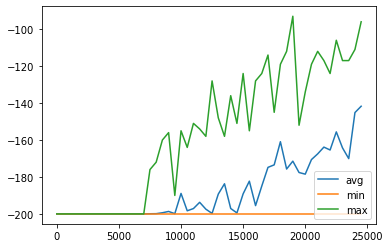

In [ ]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label='avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label='min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label='max')
plt.legend(loc = 4)
plt.show()

# DDQN

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


**Agent**

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from collections import deque
import random
import numpy as np
 
class DQNAgent:
  def __init__(self, env):
    self.env     = env
    self.memory  = deque(maxlen=2000)
        
    self.discount = 0.99
    self.epsilon = 1
    self.epsilon_min = 0
    self.epsilon_decay = 0.995
    self.learning_rate = 1e-3
    self.tau = 0.05
    self.batch_size = 32
 
    self.model = self.create_model()
    self.target_model = self.create_model()
 
  def create_model(self):
    model = Sequential()
    state_shape = self.env.observation_space.shape
    model.add(Dense(32, input_dim=state_shape[0], activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(self.env.action_space.n))
    model.compile(loss="mse",optimizer=Adam(lr=self.learning_rate))
    return model
 
  def remember(self, state, action, reward, new_state, done):
    self.memory.append([state, action, reward, new_state, done])
 
  def replay(self):
    if len(self.memory) < self.batch_size:
      return
    
    samples = random.sample(self.memory, self.batch_size)
    for sample in samples:
      state, action, reward, new_state, done = sample
      target = self.target_model.predict(state)
      if done:
        target[0][action] = reward
      else:
        Q_future = max(self.target_model.predict(new_state)[0])
        target[0][action] = reward + Q_future * self.discount
      self.model.fit(state, target, epochs = 1, verbose=0)
 
  def target_train(self):
    weights = self.model.get_weights()
    target_weights = self.target_model.get_weights()
    for i in range(len(target_weights)):
      target_weights[i] = weights[i]
    self.target_model.set_weights(target_weights)
 
  def act(self, state):
    self.epsilon *= self.epsilon_decay
    self.epsilon = max(self.epsilon_min, self.epsilon)
    if np.random.random() < self.epsilon:
      return self.env.action_space.sample()
    return np.argmax(self.model.predict(state)[0])
 
  def save_model(self, filename='/gdrive/My Drive/Cartpole_files/model.h5'):
    self.model.save(filename)
 
  def load_model(self, filename):
    self.model = load_model(filename, compile=True)

In [ ]:
import gym
from tqdm import tqdm
import time
import pandas as pd
 
#initialize environment and agent
 
env = gym.make('CartPole-v0')
unda = env.reset()
 
agent = DQNAgent(env)
 
agent.load_model('/gdrive/My Drive/Cartpole_files/Sun Sep 13 12:03:57 2020.h5') #comment out these if not needed
agent.epsilon = 0
 
trials  = 200 #trials is no of episodes
trial_len = 210 #no of steps to take
total_score = []
actions = []
save_every = 30 #save stats to drive at every - steps
 
#for logs
logs = {'episode':[],
        'score':[],
        'epsilon':[]}
 
for trail in tqdm(range(trials)):
  cur_state = env.reset().reshape(1,len(unda))
  score = 0
  actions_trail = []
  for step in (range(trial_len)):
    action = agent.act(cur_state)
    new_state, reward, done, _ = env.step(action)
 
    actions_trail.append(action)
 
    score += reward
    new_state = new_state.reshape(1,len(unda))
    agent.remember(cur_state, action, reward, new_state, done)
 
    agent.replay()
    agent.target_train()
 
    cur_state = new_state
    if done:
      break
 
  logs['episode'].append(trail)
  logs['epsilon'].append(agent.epsilon)
  logs['score'].append(score)
 
  if (trail % save_every == 0):
 
    file_name ='/gdrive/My Drive/Cartpole_files/' + time.asctime( time.localtime(time.time()) ) + '.npy'
    np.save(file_name,actions)
    file_name ='/gdrive/My Drive/Cartpole_files/' + time.asctime( time.localtime(time.time()) ) + '.h5'
    agent.save_model(file_name)
 
    file_name ='/gdrive/My Drive/Cartpole_files/' + time.asctime( time.localtime(time.time()) ) + '.csv'
    df = pd.DataFrame(logs)
    df.to_csv(file_name,index=False)
 
  actions.append(actions_trail)
  total_score.append(score)
  avgs = sum(total_score[-100:])/100
  if avgs >= 195:
    print('done')
    break
 
actions = np.array(actions)
np.save('/gdrive/My Drive/Cartpole_files/actions200final.npy',actions)
agent.save_model()

 52%|█████▏    | 104/200 [6:11:06<4:05:59, 153.74s/it]

In [ ]:
print(total_score)

[9.0, 17.0]


In [ ]:
test = []
for i in range(30*500):
  test.append(i)
test = np.array(test)
np.save('/tmp/test.npy',test)

In [ ]:
aaaa = np.load('/gdrive/My Drive/Cartpole_files/actions2.npy', allow_pickle=True)
print(len(aaaa[24]))

200


# Tf-agents
its not mine its not completed just copied it for some testing

In [ ]:
!pip install tf-agents

     |████████████████████████████████| 1.1MB 2.8MB/s 


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

In [ ]:
env_name = "CartPole-v1" # @param {type:"string"}
num_iterations = 15000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [ ]:
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.compat.v2.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

compute_avg_return(eval_env, random_policy, num_eval_episodes)

25.9

In [ ]:
#@test {"skip": true}
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
  collect_step(train_env, random_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)